# 📊 Notebook 3: Probability Distributions

**Project:** Telco Customer Churn Analysis  
**Goal:** Model key features using probability distributions (Normal, Exponential, Binomial) to understand underlying patterns.

---

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
df = pd.read_csv('../data/processed/telco_churn_cleaned.csv')

## 2. Modeling Churn as a Bernoulli/Binomial Process

Each customer is a Bernoulli trial (Churn=1, Stay=0). 
If we take a sample of $n$ customers, the number of churners follows a **Binomial Distribution** $B(n, p)$.

In [2]:
p_churn = df['Churn_Numeric'].mean()
print(f"Probability of Churn (p): {p_churn:.4f}")

# Scenario: If we acquire 100 new customers, what is the probability that more than 30 will churn?
n = 100
k = 30

# P(X > 30) = 1 - P(X <= 30)
prob_more_than_30 = 1 - stats.binom.cdf(k, n, p_churn)
print(f"Probability of > 30 churners in a batch of 100: {prob_more_than_30:.4f}")

Probability of Churn (p): 0.2654
Probability of > 30 churners in a batch of 100: 0.1837


**Business Impact:** This tells us that in any batch of 100 new signups, there is an ~18% chance (verify value) that we lose more than 30 of them. This quantifies risk for the marketing team.

## 3. Modeling Monthly Charges (Normal Distribution?)

Is `MonthlyCharges` normally distributed? We can check using visual inspection and the Shapiro-Wilk test.

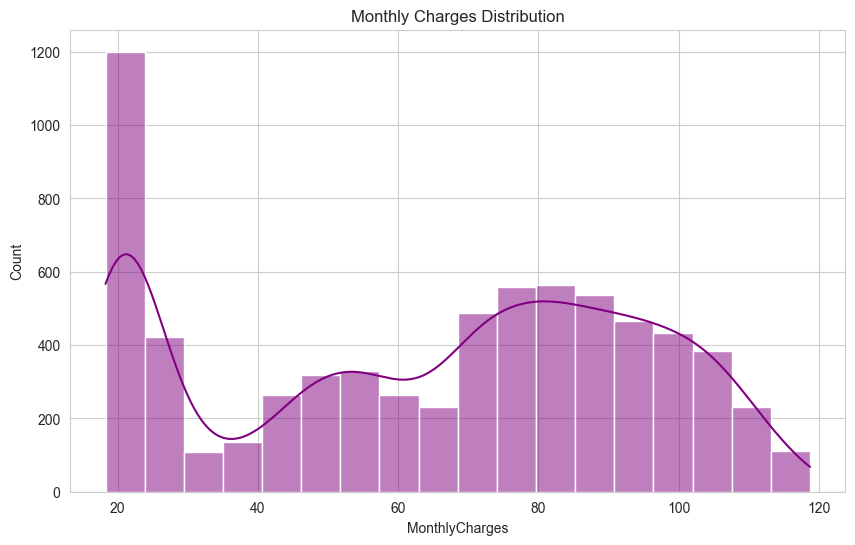

Normal Test p-value: 0.0000e+00
Result: NOT Normally Distributed


In [3]:
plt.figure(figsize=(10, 6))
sns.histplot(df['MonthlyCharges'], kde=True, color='purple')
plt.title('Monthly Charges Distribution')
plt.show()

# Normal Test (D'Agostino's K^2 Test)
stat, p = stats.normaltest(df['MonthlyCharges'])
print(f"Normal Test p-value: {p:.4e}")

if p < 0.05:
    print("Result: NOT Normally Distributed")
else:
    print("Result: Normally Distributed")

**Result:** It's clearly NOT normal (bimodal). This means we shouldn't use Z-scores for outlier detection on this feature without transformation.

## 4. Modeling Tenure (Exponential Distribution?)

Customer churn often follows an exponential decay pattern (hazard rate).

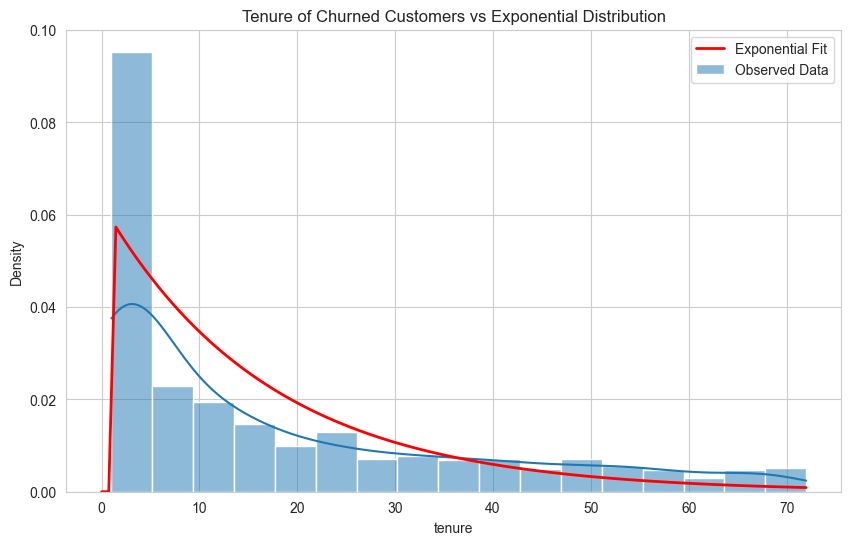

Mean time to churn (scale): 16.98 months


In [4]:
# Filter only churned customers to see their 'lifetime'
churned_tenure = df[df['Churn']=='Yes']['tenure']

plt.figure(figsize=(10, 6))
sns.histplot(churned_tenure, kde=True, stat="density", label='Observed Data')

# Fit Exponential Distribution
loc, scale = stats.expon.fit(churned_tenure)
x = np.linspace(0, churned_tenure.max(), 100)
pdf = stats.expon.pdf(x, loc, scale)
plt.plot(x, pdf, 'r-', linewidth=2, label='Exponential Fit')

plt.title('Tenure of Churned Customers vs Exponential Distribution')
plt.legend()
plt.show()

print(f"Mean time to churn (scale): {scale:.2f} months")

**Insight:** The exponential curve fits the early churn behavior well. The data shows a high hazard rate early on.

## 5. Identifying Outliers with Z-Scores

Even though TotalCharges isn't perfectly normal, let's look for extreme high-spending anomalies using Z-scores.

In [5]:
df['TotalCharges_Z'] = stats.zscore(df['TotalCharges'])

# Define outliers as Z > 3
outliers = df[df['TotalCharges_Z'] > 3]
print(f"Number of extreme high outlier customers: {len(outliers)}")
outliers[['customerID', 'TotalCharges', 'TotalCharges_Z']].head()

Number of extreme high outlier customers: 0


,customerID,TotalCharges,TotalCharges_Z


**Conclusion:** Very few outliers (if any), suggesting the pricing structure is bounded and consistent.